In [1]:
import sys
import numpy as np
import pandas as pd
import shap
import os
import pickle
import matplotlib.pyplot as plt

sys.path.append("..")

from src.pickle_manager import open_pickle
from src.evaluation import combine_multiple_one_hot_multiclass
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
rf = open_pickle(os.path.join("..", "data", "models"), "rf_classifier_2.pkl")
lr = open_pickle(os.path.join("..", "data", "models"), "log_reg_2.pkl")
xgb = open_pickle(os.path.join("..", "data", "models"), "xgb_classifier_2.pkl")

data = open_pickle(os.path.join("..", "data", "pkls"), "processed_dataset_classification_2.pkl")
X_train, X_test, y_train, y_test = (
    data[0],
    data[1],
    data[2],
    data[3],
)

In [3]:
original_categorical_features = ["Основной вид деятельности", "Регион", "КатСубМСП"]
feature_names = X_test.columns.tolist()

# Initialize a list for masks corresponding to each categorical feature
masks = []
names = []


for feature in original_categorical_features:
    # Create a mask with False for each column
    feature_mask = [False] * X_test.shape[1]

    # Find columns in X_test that start with the name of the categorical feature
    for col in X_test.columns:
        if col.startswith(feature):
            # Get the index of the column and set the corresponding mask element to True
            idx = X_test.columns.get_loc(col)
            feature_mask[idx] = True

    # Add the mask to the list of masks
    masks.append(feature_mask)
    names.append(feature)

In [4]:
# Create an aggregated 
# Create a copy of X_test to work with
X_test_aggregated = X_test.copy()

for feature in original_categorical_features:
    # Identify one-hot encoded columns for this feature
    one_hot_cols = [col for col in X_test.columns if col.startswith(feature)]

    # Aggregate the one-hot encoded columns
    X_test_aggregated[feature] = X_test_aggregated[one_hot_cols].idxmax(axis=1).apply(lambda x: int(x.split("_", 1)[1]))

    # Drop the original one-hot encoded columns
    X_test_aggregated.drop(columns=one_hot_cols, inplace=True)


###  Linear Regression

In [5]:
# Create the SHAP explainer
explainer = shap.LinearExplainer(lr, X_train)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

In [6]:
# Combining SHAP values for a specific one-hot encoded feature
aggregated_shap_values_multiclass = combine_multiple_one_hot_multiclass(shap_values, feature_names, names, masks)
aggregated_values = [x[0] for x in aggregated_shap_values_multiclass]
aggregated_feature_names = aggregated_shap_values_multiclass[0][1]

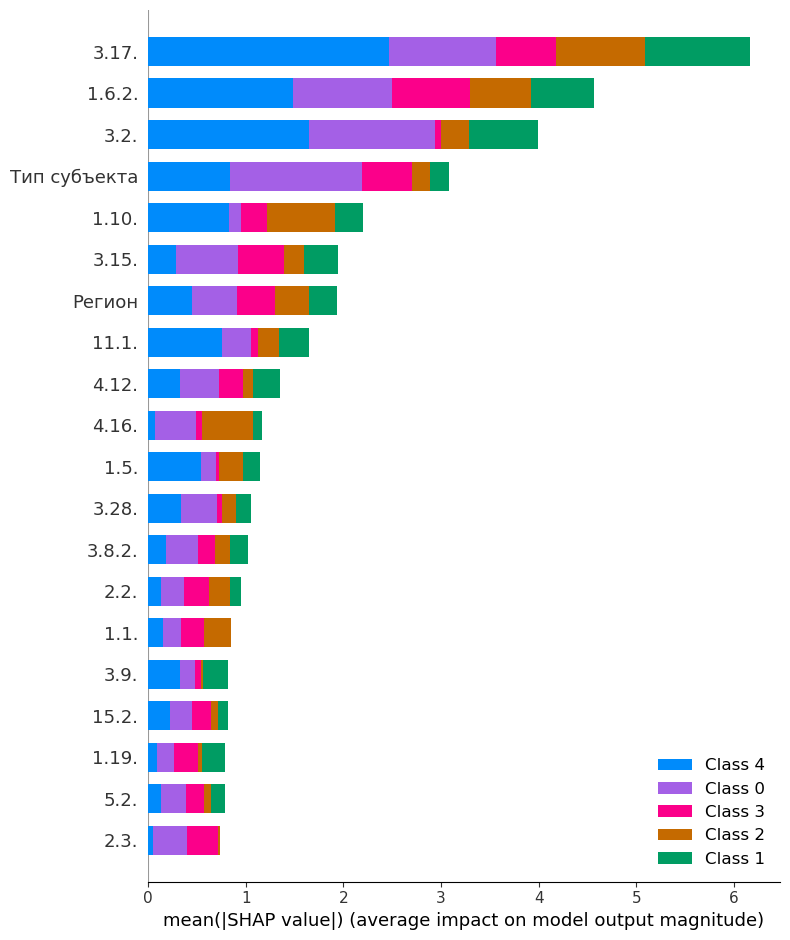

In [7]:
shap.summary_plot(aggregated_values, feature_names=aggregated_feature_names, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


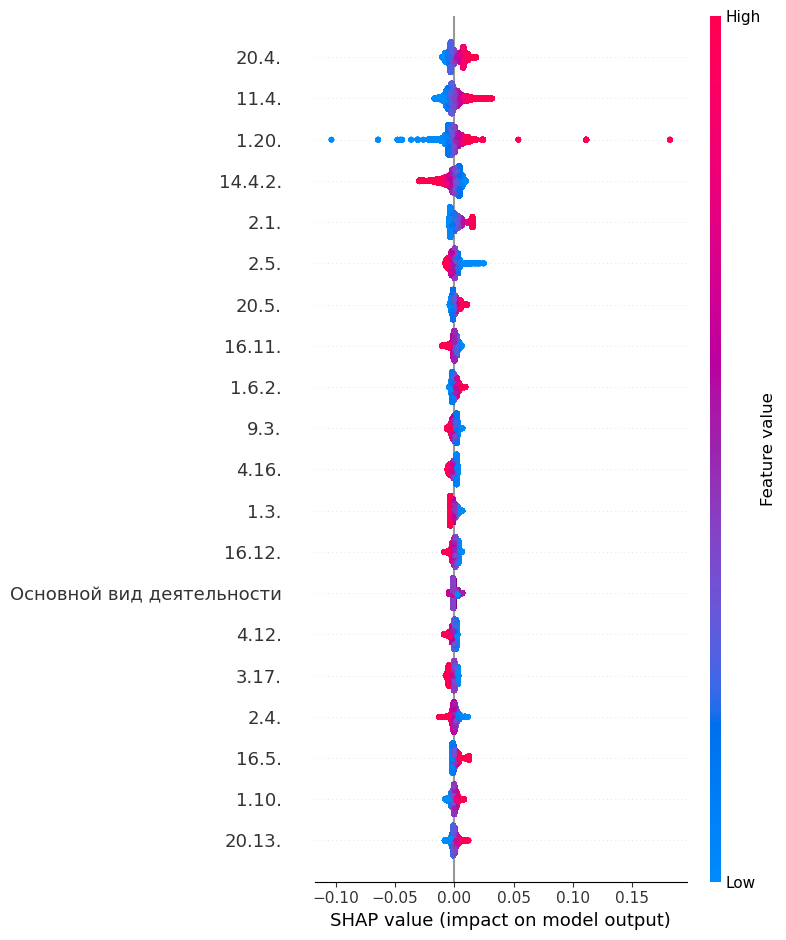

In [8]:
# Global feature importance
shap.summary_plot(np.average(aggregated_values, axis=0), X_test_aggregated)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


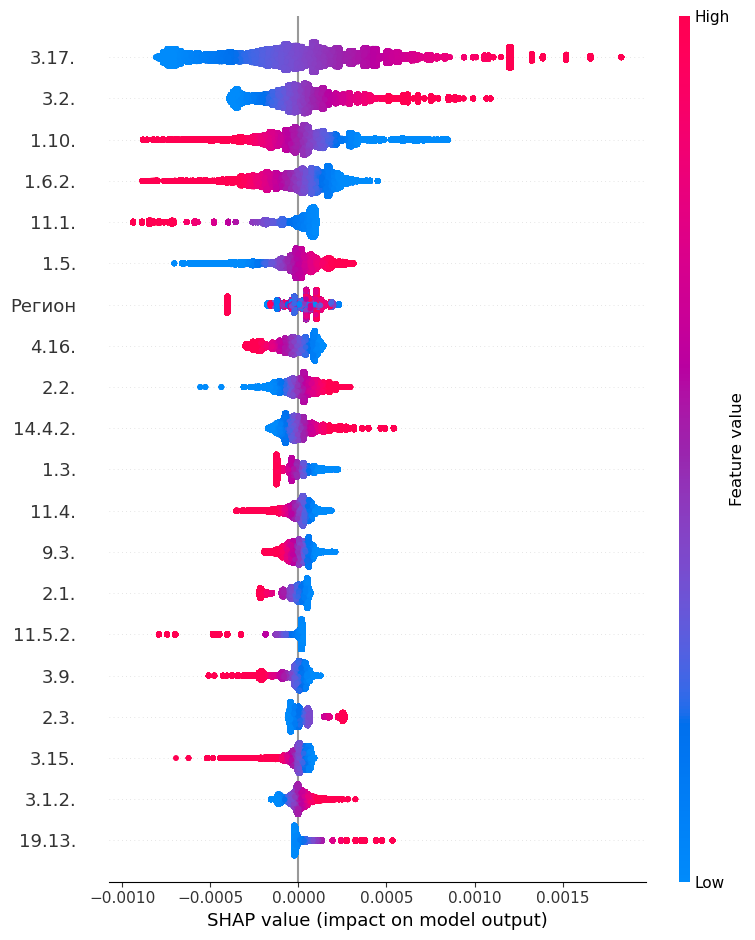

In [9]:
# Normalizing SHAP values (optional)
normalized_shap_values = [aggregated_values[i] / np.linalg.norm(aggregated_values[i]) for i in range(len(aggregated_values))]

# Summing the normalized SHAP values across classes
summed_shap_values = np.sum(normalized_shap_values, axis=0)

# Global feature importance
shap.summary_plot(summed_shap_values, X_test_aggregated)

###  Xgboost

In [10]:
# Create the SHAP explainer
explainer = shap.TreeExplainer(xgb, X_train[:10000])

# Compute SHAP values
shap_values = explainer.shap_values(X_test[:10000], y_test[:10000])

[06:55:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 49999/50000 [393:45<00:00]         

In [11]:
# Combining SHAP values for a specific one-hot encoded feature
aggregated_shap_values_multiclass = combine_multiple_one_hot_multiclass(shap_values, feature_names, names, masks)
aggregated_values = [x[0] for x in aggregated_shap_values_multiclass]
aggregated_feature_names = aggregated_shap_values_multiclass[0][1]

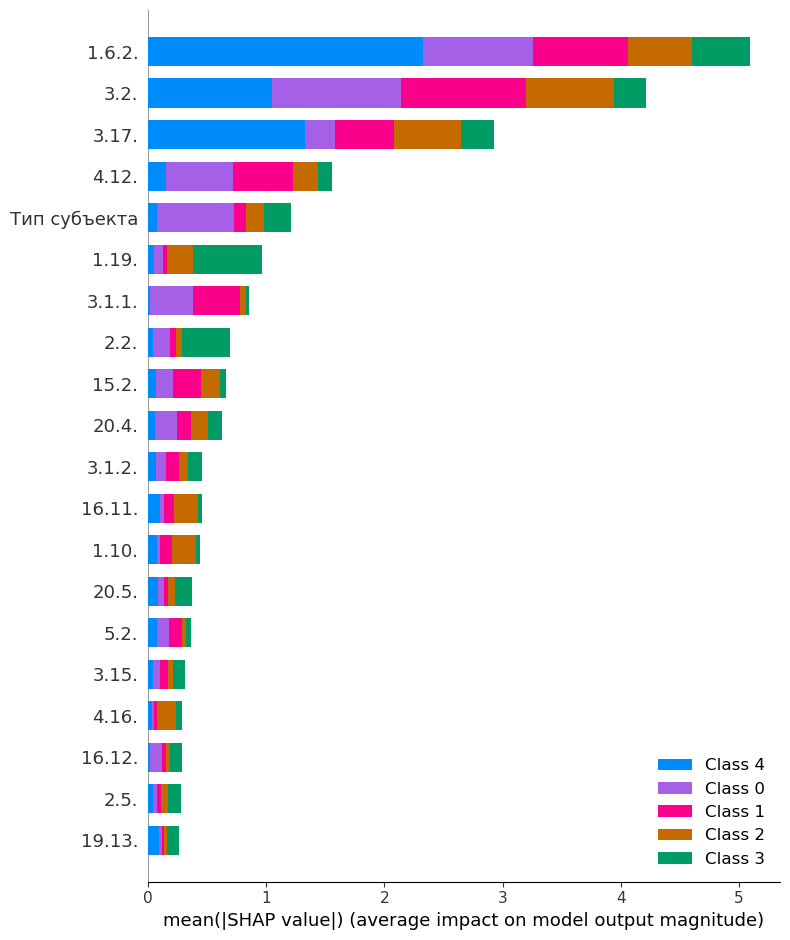

In [12]:
shap.summary_plot(aggregated_values, feature_names=aggregated_feature_names, plot_type="bar")


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


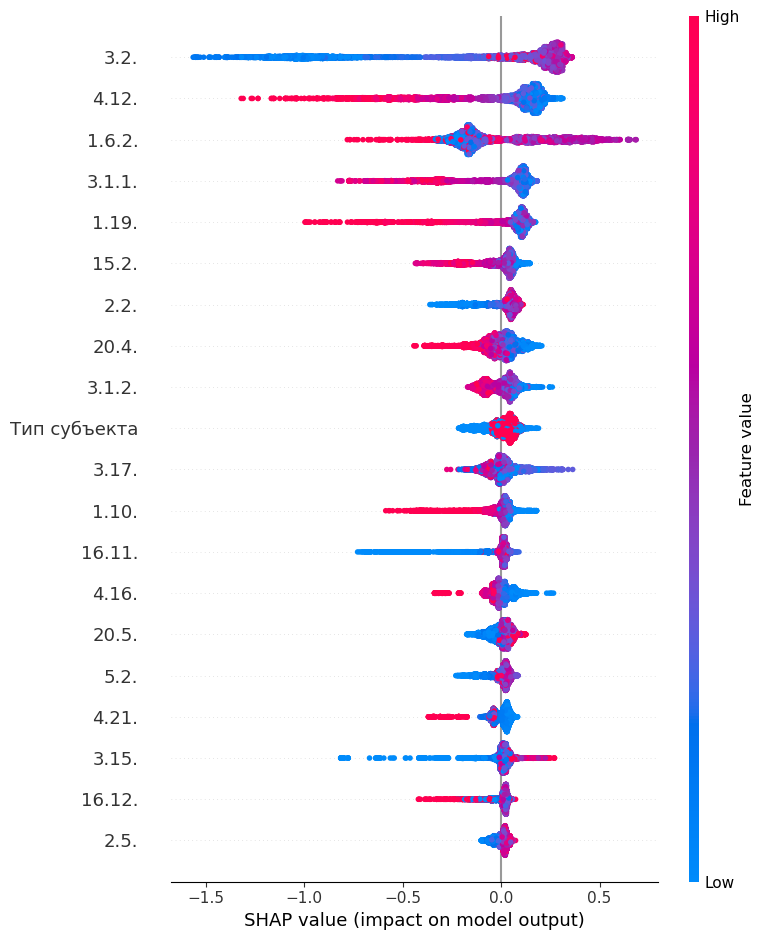

In [13]:
# Global feature importance
shap.summary_plot(np.average(aggregated_values, axis=0), X_test_aggregated[:10000])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


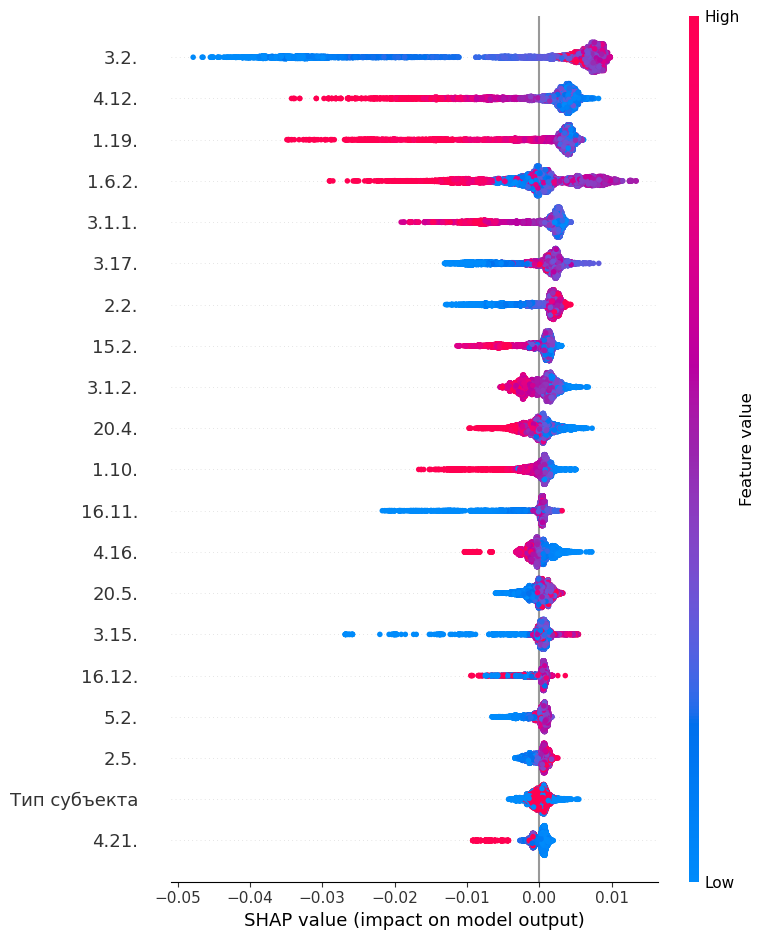

In [14]:
# Normalizing SHAP values (optional)
normalized_shap_values = [aggregated_values[i] / np.linalg.norm(aggregated_values[i]) for i in range(len(aggregated_values))]

# Summing the normalized SHAP values across classes
summed_shap_values = np.sum(normalized_shap_values, axis=0)

# Global feature importance
shap.summary_plot(summed_shap_values, X_test_aggregated[:10000])